In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [27]:
# Step 1: Load and Preprocess the KDD Cup 1999 Dataset

# Define the column names as per the dataset
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

# Load the dataset
data_path = 'dataset/kddcup.data_10_percent_corrected'  # Adjust this path accordingly
data = pd.read_csv(data_path, header=None, names=column_names)

# Split the dataset into features and labels
X = data.drop(columns=['label'])
y = data['label']

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit the scaler on the training data and transform the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Ensure the test data has the same columns as the train data
# Reindex to align with the training data and fill missing columns with zeros
X_test_transformed = pd.DataFrame(X_test_transformed).reindex(
    columns=pd.DataFrame(X_train_transformed).columns, fill_value=0
).values


In [28]:
# Step 2: Define and Train the Autoencoder

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

# Define the dimensions
input_dim = X_train_transformed.shape[1]
latent_dim = 32  # Latent space dimension

# Instantiate the autoencoder
autoencoder = Autoencoder(input_dim, latent_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Convert the preprocessed training data to torch tensor
train_features_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)

# Training loop for the autoencoder
num_epochs = 250
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    outputs = autoencoder(train_features_tensor)
    loss = criterion(outputs, train_features_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained autoencoder model
torch.save(autoencoder.state_dict(), 'autoencoder_new.pth')
print("Autoencoder model saved as 'autoencoder_new.pth'")

# Encode the training and test data
with torch.no_grad():
    encoded_X_train = autoencoder.encode(train_features_tensor).numpy()
    test_features_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)
    encoded_X_test = autoencoder.encode(test_features_tensor).numpy()


Epoch [1/250], Loss: 0.5573
Epoch [2/250], Loss: 0.5554
Epoch [3/250], Loss: 0.5535
Epoch [4/250], Loss: 0.5516
Epoch [5/250], Loss: 0.5496
Epoch [6/250], Loss: 0.5474
Epoch [7/250], Loss: 0.5450
Epoch [8/250], Loss: 0.5424
Epoch [9/250], Loss: 0.5395
Epoch [10/250], Loss: 0.5363
Epoch [11/250], Loss: 0.5327
Epoch [12/250], Loss: 0.5287
Epoch [13/250], Loss: 0.5242
Epoch [14/250], Loss: 0.5192
Epoch [15/250], Loss: 0.5136
Epoch [16/250], Loss: 0.5073
Epoch [17/250], Loss: 0.5003
Epoch [18/250], Loss: 0.4925
Epoch [19/250], Loss: 0.4839
Epoch [20/250], Loss: 0.4744
Epoch [21/250], Loss: 0.4641
Epoch [22/250], Loss: 0.4529
Epoch [23/250], Loss: 0.4411
Epoch [24/250], Loss: 0.4286
Epoch [25/250], Loss: 0.4159
Epoch [26/250], Loss: 0.4030
Epoch [27/250], Loss: 0.3903
Epoch [28/250], Loss: 0.3781
Epoch [29/250], Loss: 0.3667
Epoch [30/250], Loss: 0.3563
Epoch [31/250], Loss: 0.3473
Epoch [32/250], Loss: 0.3395
Epoch [33/250], Loss: 0.3332
Epoch [34/250], Loss: 0.3280
Epoch [35/250], Loss: 0

In [29]:
# Step 3: Define and Train the Classifier

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the classifier
num_classes = len(np.unique(y_train))
classifier = Classifier(input_dim=latent_dim, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch processing
train_dataset = TensorDataset(torch.tensor(encoded_X_train, dtype=torch.float32), y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop for the classifier
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save the trained classifier model
torch.save(classifier.state_dict(), 'classifier_model.pth')
print("Classifier model saved as 'classifier_model.pth'")



Epoch [1/250], Loss: 0.0378
Epoch [2/250], Loss: 0.0146
Epoch [3/250], Loss: 0.0114
Epoch [4/250], Loss: 0.0101
Epoch [5/250], Loss: 0.0092
Epoch [6/250], Loss: 0.0091
Epoch [7/250], Loss: 0.0082
Epoch [8/250], Loss: 0.0077
Epoch [9/250], Loss: 0.0078
Epoch [10/250], Loss: 0.0076
Epoch [11/250], Loss: 0.0069
Epoch [12/250], Loss: 0.0072
Epoch [13/250], Loss: 0.0069
Epoch [14/250], Loss: 0.0068
Epoch [15/250], Loss: 0.0066
Epoch [16/250], Loss: 0.0070
Epoch [17/250], Loss: 0.0063
Epoch [18/250], Loss: 0.0065
Epoch [19/250], Loss: 0.0062
Epoch [20/250], Loss: 0.0065
Epoch [21/250], Loss: 0.0060
Epoch [22/250], Loss: 0.0062
Epoch [23/250], Loss: 0.0058
Epoch [24/250], Loss: 0.0057
Epoch [25/250], Loss: 0.0063
Epoch [26/250], Loss: 0.0056
Epoch [27/250], Loss: 0.0066
Epoch [28/250], Loss: 0.0062
Epoch [29/250], Loss: 0.0061
Epoch [30/250], Loss: 0.0058
Epoch [31/250], Loss: 0.0059
Epoch [32/250], Loss: 0.0057
Epoch [33/250], Loss: 0.0059
Epoch [34/250], Loss: 0.0058
Epoch [35/250], Loss: 0

Reconstruction Error (MSE) on the test set: 6.574063301086426


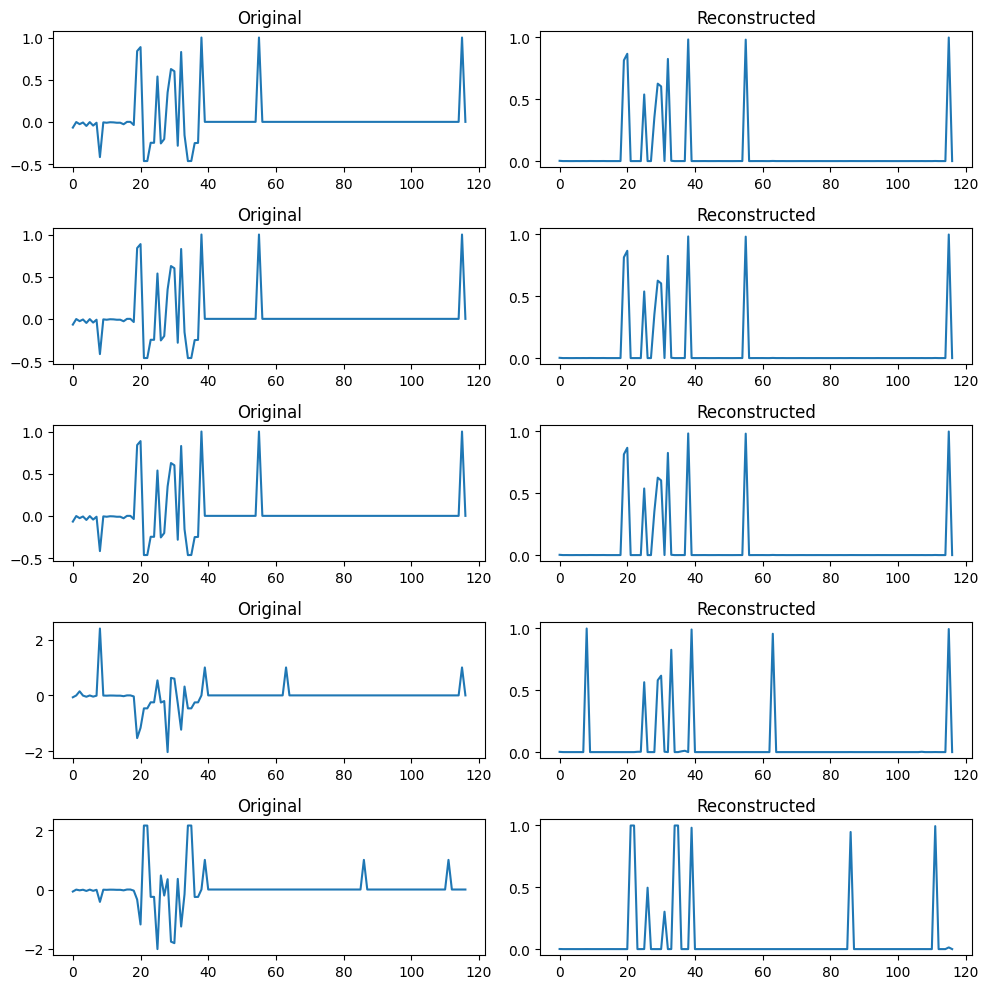

In [30]:
# Step 4: Evaluate the Autoencoder
s
# Reconstruct the test data using the autoencoder
with torch.no_grad():
    reconstructed = autoencoder(test_features_tensor)

# Compute the reconstruction error (MSE)
reconstruction_error = criterion(reconstructed, test_features_tensor).item()
print(f'Reconstruction Error (MSE) on the test set: {reconstruction_error}')

# Visualize some of the original and reconstructed data
num_examples = 5
fig, axes = plt.subplots(num_examples, 2, figsize=(10, 10))

for i in range(num_examples):
    axes[i, 0].plot(test_features_tensor[i].numpy())
    axes[i, 0].set_title('Original')
    axes[i, 1].plot(reconstructed[i].numpy())
    axes[i, 1].set_title('Reconstructed')

plt.tight_layout()
plt.show()


In [45]:
def predict_attack_type_pytorch(classifier, autoencoder, label_encoder, categorical_features, user_input):
    # Convert user input to DataFrame
    user_df = pd.DataFrame([user_input])
    
    # Align user input with training data columns and fill missing columns
    user_df = pd.get_dummies(user_df, columns=categorical_features)
    # Assuming X_train_transformed is the transformed training data used for alignment
    user_df = user_df.reindex(columns=pd.DataFrame(X_train_transformed).columns, fill_value=0)

    # Handle any potential misalignment in dtypes
    for col in user_df.columns:
        if user_df[col].dtype == 'O':
            user_df[col] = user_df[col].astype(float)

    # Transform using the preprocessor (ensure compatibility)
    scaled_user_input = user_df.values

    # Convert to tensor for prediction
    user_input_tensor = torch.tensor(scaled_user_input, dtype=torch.float32)
    
    # Reduce the dimensions using the autoencoder
    with torch.no_grad():
        encoded_input = autoencoder.encode(user_input_tensor)
    
    # Predict the attack type using the classifier
    classifier.eval()
    with torch.no_grad():
        output = classifier(encoded_input)
        _, predicted = torch.max(output, 1)
    
    # Decode the predicted label back to the attack type
    predicted_label = label_encoder.inverse_transform(predicted.numpy())[0]
    
    return predicted_label


In [46]:
# Example usage of predict_attack_type_pytorch function

user_input_normal = {
    'duration': 0,
    'protocol_type': 'udp',        # Assuming TCP protocol for normal traffic
    'service': 'private',             # Common service for normal web browsing
    'flag': 'S0',                  # Flag indicating a connection is established and no unusual conditions
    'src_bytes': 0,
    'dst_bytes': 0,
    'land': 0,
    'wrong_fragment': 0,
    'urgent': 0,
    'hot': 0,
    'num_failed_logins': 0,
    'logged_in': 0,                # Assuming not logged in for normal activity
    'num_compromised': 0,
    'root_shell': 0,
    'su_attempted': 0,
    'num_root': 0,
    'num_file_creations': 0,
    'num_shells': 0,
    'num_access_files': 0,
    'num_outbound_cmds': 0,
    'is_host_login': 0,
    'is_guest_login': 0,
    'count': 254,                    # Low count for interactions as typical in normal scenarios
    'srv_count': 14,
    'serror_rate': 1.0,
    'srv_serror_rate': 1.0,
    'rerror_rate': 0.0,
    'srv_rerror_rate': 0.0,
    'same_srv_rate': 0.06,
    'diff_srv_rate': 0.06,
    'srv_diff_host_rate': 0.0,
    'dst_host_count': 255,
    'dst_host_srv_count': 14,
    'dst_host_same_srv_rate': 0.05,
    'dst_host_diff_srv_rate': 0.06,
    'dst_host_same_src_port_rate': 0.00,   # Low rate of same source port connections
    'dst_host_srv_diff_host_rate': 0.0,
    'dst_host_serror_rate': 1.0,
    'dst_host_srv_serror_rate': 1.0,
    'dst_host_rerror_rate': 0.0,
    'dst_host_srv_rerror_rate': 0.0
}

# Predict the attack type for the example user input
predicted_attack = predict_attack_type_pytorch(classifier, autoencoder, label_encoder, categorical_features,user_input_normal)
print(f'Predicted Attack Type: {predicted_attack}')


Predicted Attack Type: smurf.
